# Variant Findings Plot

Plotting variant findings and metadata into a single plot by using an oncoplot (oncoprint) for visualization of cohort
level variant visualization.

## Variant and Metadata

Variant tags and metadata for the whole cohort are no longer used but can be found:
  - [cohort oncoprint](../data/processed/all_samples_mecfs_cohort_oncoprint.tsv)
  - [cohort metadata](../data/processed/all_samples_mecfs_cohort_metadata.tsv)

The data used for this plot have been filtered to a selection of genes for a focused plot of strong findings. This plot includes the molecular
categories of the participants, which is based on their molecular findings. The general text describing these is:

```text
1. Energy Production and Metabolism: Pathogenic variants in ENO3, HADHA, ACADM, and MMACHC impact mitochondrial function, fatty acid oxidation, or glycolysis associated with exertion-related fatigue and metabolic disturbances characteristic of ME/CFS.
2. Solute Transport and Balance: Pathogenic variants in KCNJ18 and SLC12A3 affecting ion channels associated with fatigue, cramping, and electrolyte imbalances characteristic of ME/CFS, particularly in response to stress or exertion.
3. Red Blood Cell Structural Integrity: The pathogenic variant in a gene affecting red blood cell structure (SPTA1) was seen in several participants. These may underlie persistent fatigue, muscle pain, and exertional limitations.
4. Muscle Function and Stability:  A pathogenic variant was seen  in a gene muscle function (MYH7) and extracellular matrix integrity was found in a participant. These may underlie persistent fatigue, muscle pain, and exertional limitations.
```

and this breaks down into the following simplified setup:
  - Energy Production and Metabolism
    - Participants 5, 7, 8, 15, 18
    - Genes: ENO3, ACADM, HADHA, MMACHC, ELOVL4
  - Solute Transport and Ion Homeostasis
    - Participants 1, 2, 3, 4, 19, 20
    - Genes: KCNJ18, SLC12A3
  - Red Blood Cell Membrane Integrity
    - Participants 21, 22, 23, 24, 26
    - Genes: SPTA1, GMPPB, SLC4A1
  - Muscle Structure and Stability
    - Participants 25
    - Genes: MYH7

## Plotting

In [6]:
import pyoncoprint
import pandas as pd
import matplotlib.pyplot as plt

df_oncoprint = pd.read_csv("../data/processed/mecfs_cohort_oncoprint.tsv", sep="\t", header=0, index_col="track_name")
metadata_df = pd.read_csv("../data/processed/mecfs_cohort_metadata.tsv", sep="\t", header=0, index_col="track_name")

Build the various color and data type profiles for the metadata to be displayed

In [7]:
import matplotlib.pyplot as plt
import numpy as np
cmap = plt.get_cmap('jet')

annotations = {
    "Age at Consent": {
        'annotations': metadata_df[metadata_df.index == 'Age at consent'].fillna('0').astype(float),
        'color': 'green',
        'order': 1,
    },
    "Nbr body areas w/ Pain": {
        'annotations': metadata_df[metadata_df.index == 'Total number of body areas w/Pain'].fillna('0').astype(float),
        'color': 'red',
        'order': 1,
    },
    "Symptom Severity": {
        'annotations': metadata_df[metadata_df.index == 'SS (Symptom Severity score, 0-12)'].fillna('0').astype(float),
        'color': 'blue',
        'order': 1,
    },
    "FM Severity": {
        'annotations': metadata_df[metadata_df.index == 'FM Severity (0-31)'].fillna('0').astype(float),
        'color': 'purple',
        'order': 1,
    },
}

ageonset_df = metadata_df[metadata_df.index == 'Age of Onset']
uniq_annots = sorted(pd.unique(ageonset_df.values.ravel()))
annotations['Age of Onset'] = {
    'annotations': ageonset_df,
    'colors': {k: v for k, v in zip(uniq_annots, cmap(np.linspace(0, 1, len(uniq_annots), dtype=float)))},
    'order': 2
}

sudonset_df = metadata_df[metadata_df.index == 'Sudden Onset?'].fillna('N/A')
melted_df = pd.melt(sudonset_df)
uniq_annots = sorted(melted_df['value'].unique().tolist())
annotations['Sudden Onset?'] = {
    'annotations': sudonset_df,
    'colors': {k: v for k, v in zip(uniq_annots, cmap(np.linspace(0, 1, len(uniq_annots), dtype=float)))},
    'order': 2
}

sex_df = metadata_df[metadata_df.index == 'Sex']
uniq_annots = sorted(pd.unique(sex_df.values.ravel()))
annotations['Sex'] = {
    'annotations': sex_df,
    'colors': {k: v for k, v in zip(uniq_annots, cmap(np.linspace(0, 1, len(uniq_annots), dtype=float)))},
    'order': 2
}

class_df = metadata_df[metadata_df.index == 'Class']
uniq_annots = sorted(pd.unique(class_df.values.ravel()))
annotations['Class'] = {
    'annotations': class_df,
    'colors': {
        "Red Blood Cell Membrane Integrity": "r",
        "Energy Production and Metabolism": "g",
        "Solute Transport and Ion Homeostasis": "m",
        "Muscle Structure and Stability": "b",
    },
    'order': 2
}

We need to determine all of the unique cell values in the oncoprint dataframe so we can designate shapes and colors for each.

In [8]:
from numpy import nan
uniq_labels = pd.unique(df_oncoprint.values.ravel()).tolist()
uniq_labels.remove(nan)
uniq_labels

['Hom nonsense',
 'Compound Het missense',
 'Compound Het nonsense/missense',
 'Het nonsense',
 'Het frameshift',
 'Het missense',
 'Het splicing']

Assign shapes and colors to the different variants identified across the cohort. Then plot the oncoprint.

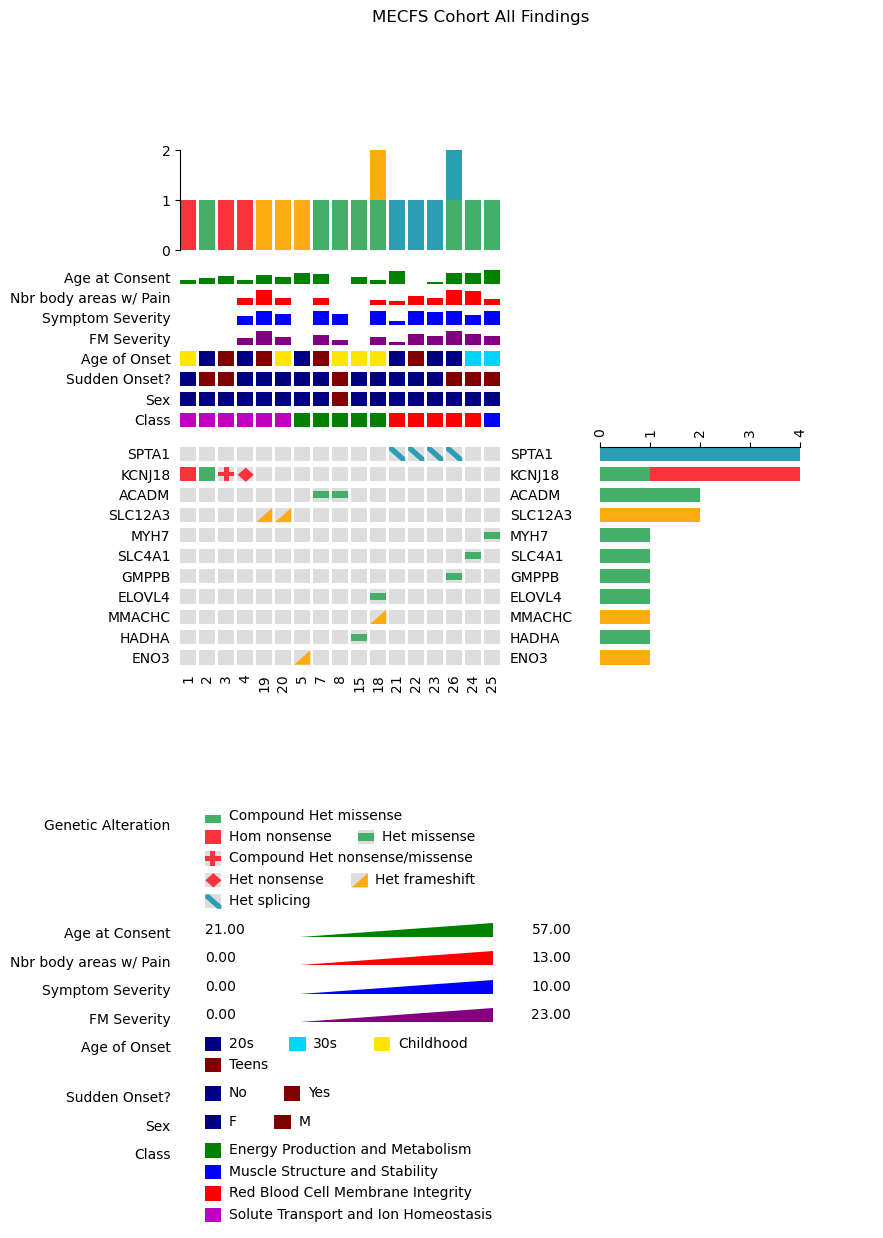

In [9]:
from matplotlib.patches import Polygon


# populate a dictionary with marker and color information for the different variant labels
primary_mods_mutation_markers = {
    "Het frameshift": {
        "marker": Polygon([[0, 0], [1, 1], [1, 0]]),  # full right angle triangle
        "lw": 0,
        "zindex": 2,
        "color": "#fcab10",
    },
    "Het splicing": {
        "marker": Polygon(
            [[0, 1], [0.25, 1], [1, 0.25], [1, 0], [0.75, 0], [0, 0.75]]
        ),  # left slash
        "lw": 0,
        "zindex": 2,
        "color": "#2b9eb3",
    },
    "Het missense": {
        "marker": "fill",
        "height": 0.5,
        "zindex": 1,
        "color": "#44af69",
    },
    "Compound Het missense": {
        "marker": "fill", # fill full cell
        "zindex": 0,
        "color": "#44af69",
    },  
    "Compound Het nonsense/missense": {
        "marker": Polygon(
            [
                [0, 0.35],
                [0, 0.65],
                [0.35, 0.65],
                [0.35, 1],
                [0.65, 1],
                [0.65, 0.65],
                [1, 0.65],
                [1, 0.35],
                [0.65, 0.35],
                [0.65, 0],
                [0.35, 0],
                [0.35, 0.35],
            ]
        ),  # plus sign
        "lw": 0,
        "zindex": 1,
        "color": "#f8333c",
    },
    "Hom nonsense": {
        "marker": "fill",  # fill full cell
        "zindex": 0,
        "color": "#f8333c",
    },
    "Het nonsense": {
        "marker": Polygon([[0, 0.5], [0.5, 1], [1, 0.5], [0.5, 0]]),  # diamond
        "lw": 0,
        "zindex": 1,
        "color": "#f8333c",
    },
}

op = pyoncoprint.OncoPrint(df_oncoprint)
# return values: figure, (oncoprint_axis, oncoprint_dual_axis, axis_top_barplot, axis_right_barplot, axis_legend)
fig, axes = op.oncoprint(
    primary_mods_mutation_markers,
    annotations=annotations,
    sample_sort_method="unsorted",
    figsize=[8, 14],
    gap=[0.15, 0.3],  # gap between cells (ratio)
    title="MECFS Cohort All Findings",
    topplot=True,
    rightplot=True,
    legend=True,
)
fig.patch.set_facecolor("white")

In [10]:
# save the figure
fig.savefig("../docs/condensed-findings-oncoprint.png", bbox_inches="tight", dpi=600)